## Model Development
A convolutional neural network (CNN) is implemented using Keras as an interface for TensorFlow. CNNs are artificial neural networks designed for image classification.

The genres were obtained by extracting data from the metadata of each .mp3 file using the mutagen python module. 

In [1]:
import warnings;
warnings.filterwarnings('ignore');

%matplotlib inline
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from numpy import argmax
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display
import random
import warnings
import os
from PIL import Image
import pathlib
import csv
from sklearn.model_selection import train_test_split
import tensorflow as tf # this includes keras, keras.layers in TensorFlow 2.0 
import skimage.io
from pydub import AudioSegment

## Melspec functions

In [2]:
def audio_file_to_mel_spectrogram(filepath, num_bins, hop_length):
    """
    Takes in the audiofile and converts it to a Mel Spectrogram
    :param filepath [string]:

    :return mel_spect [numpy.ndarray]:
    """
    # Read in audio file
    y, sr = librosa.load(filepath, sr=None, mono=True)

    # Get image window (aka image length)
    window = create_image_window(y, hop_length)

    # Get Mel Spectrogram Features
    mel_spect = librosa.feature.melspectrogram(y=window, sr=sr,
                                               n_fft=hop_length*2,
                                               n_mels=num_bins,
                                               hop_length=hop_length)
    # Convert to Db
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)

    return mel_spect


def mel_spectrogram_to_plot(mel_spectrogram):
    """
    Shows each audio clip as a Mel Spectrogram using Matplotlib to plot this
    feature
    :param mel_spectrogram:
    :param num_bins (number of bins in spectrogram, height of image):
    :param hop_length (number of samples per time-step in spectrogram):
    :return None:
    """
    fig, ax = plt.subplots()
    img = librosa.display.specshow(mel_spectrogram, y_axis='mel', fmax=8000,
                                   x_axis='time', ax=ax)
    ax.set(title='Mel spectrogram display')
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    plt.show()


def create_image_window(y, hop_length):
    """
    Creates how wide the image is with respect to the audio clip
    :param y:
    :param hop_length:
    :return:
    """
    time_steps = 384  # number of time-steps. Width of image

    # extract a fixed length window
    start_sample = 0  # starting at beginning

    length_samples = time_steps * hop_length

    window = y[start_sample:start_sample + length_samples]

    return window


def image_diminsions(X, min=0.0, max=1.0):
    """
    Scales the Mel Spectrogram data so it fits within an 8-bit range
    :param X:
    :param min:
    :param max:
    :return:
    """
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled


def mel_spectrogram_to_image(mel_spectrogram_data, output):
    """
    Converts Mel Spectrogram data into png images
    :param mel_spectrogram_data:
    :param output:
    :return:
    """

    # min-max scale to fit inside 8-bit range
    img = image_diminsions(mel_spectrogram_data, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0)  # put low frequencies at the bottom in image
    img = 255 - img             # invert. make black==more energy

    # save as PNG
    skimage.io.imsave(output, img)

## Building the Dataset
#### Splitting mp3 here, only needs to be done once

In [3]:
# Perform image augmentation to create additional spectrographs (suggest trying with and without)
# Ref: https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-2.html
# Ref: https://keras.io/api/preprocessing/image/
# Load Libraries

MP3_DIR = '/home/atj64/Downloads/fma_small/'
IMG_DIR = '/home/atj64/Downloads/fma_melspecs/'
MP3_SPLIT_DIR = '/home/atj64/Downloads/fma_small_split/'
IMG_SPLIT_DIR = '/home/atj64/Downloads/fma_melspecs_split/'
wd = os.chdir(MP3_DIR)
genres = os.listdir(wd)
genre_dict = {}
for x, genre in enumerate(genres):
    wd = os.chdir(IMG_DIR)
    os.mkdir(genre)
    wd = os.chdir(MP3_SPLIT_DIR)
    os.mkdir(genre)
    wd = os.chdir(IMG_SPLIT_DIR)
    os.mkdir(genre)
    genre_dict[genre] = x
print(genre_dict)

for genre in genres:
    print(genre)
    genre_dir = os.chdir(MP3_DIR + genre)
    songs = os.listdir(genre_dir)
    for song in songs:
        for split in range(0,10):
            start = 3*(split)*1000
            end = 3*(split+1)*1000
            split_song = AudioSegment.from_file(MP3_DIR+genre+'/'+song, format="mp3")
            splote = split_song[start:end]
            splote.export(MP3_SPLIT_DIR+genre+'/' + str(split) + '-'+song, format='mp3')
        #make full song melspec
        try:
            spec = audio_file_to_mel_spectrogram(MP3_DIR+genre+'/'+song, num_bins=128,hop_length=512)
            mel_spectrogram_to_image(spec, IMG_DIR+genre+'/'+song[:-4]+'.png')
        except:
            print("Skipping: " + genre + " " + song)

#make split melspec
for genre in genres:
    print("Split " + genre)
    genre_dir = os.chdir(MP3_SPLIT_DIR + genre)
    songs = os.listdir(genre_dir)
    for song in songs:
        try:
            spec = audio_file_to_mel_spectrogram(MP3_SPLIT_DIR+genre+'/'+song, num_bins=128, hop_length=512)
            mel_spectrogram_to_image(spec, IMG_SPLIT_DIR+genre+'/'+song[:-4]+'.png')
        except:
            print("Skipping split: " + genre + " " + song)

{'Instrumental': 0, 'Hip-Hop': 1, 'Folk': 2, 'Pop': 3, 'Experimental': 4, 'Electronic': 5, 'International': 6, 'Rock': 7}
Instrumental
Hip-Hop
Folk
Pop
Experimental
Electronic
International
Rock
Split Instrumental
Split Hip-Hop
Skipping split: Hip-Hop 8-098569.mp3
Skipping split: Hip-Hop 7-098569.mp3
Skipping split: Hip-Hop 9-098565.mp3
Skipping split: Hip-Hop 2-098569.mp3
Skipping split: Hip-Hop 1-098567.mp3
Skipping split: Hip-Hop 3-098569.mp3
Skipping split: Hip-Hop 8-098565.mp3
Skipping split: Hip-Hop 4-098565.mp3
Skipping split: Hip-Hop 3-098565.mp3
Skipping split: Hip-Hop 4-098567.mp3
Skipping split: Hip-Hop 8-098567.mp3
Skipping split: Hip-Hop 9-098567.mp3
Skipping split: Hip-Hop 6-098569.mp3
Skipping split: Hip-Hop 1-098565.mp3
Skipping split: Hip-Hop 3-098567.mp3
Skipping split: Hip-Hop 5-098565.mp3
Skipping split: Hip-Hop 5-098567.mp3
Skipping split: Hip-Hop 6-098565.mp3
Skipping split: Hip-Hop 5-098569.mp3
Skipping split: Hip-Hop 6-098567.mp3
Skipping split: Hip-Hop 1-098569

In [6]:
#split into train/test
import shutil
TRAIN_DIR = '/home/atj64/Downloads/train/'
VAL_DIR = '/home/atj64/Downloads/val/'

for genre in genres:
    os.mkdir(VAL_DIR + genre)
    os.mkdir(TRAIN_DIR + genre)
    wd = os.chdir(IMG_SPLIT_DIR + genre)
    files = os.listdir(wd)
    random.shuffle(files)
    i = 0
    for file in files:
        if(i < 1500):#1500 from each genre taken for val so 10% val
            shutil.copyfile(IMG_SPLIT_DIR + genre + "/" + file, VAL_DIR + genre + "/" + file)
        else:
            shutil.copyfile(IMG_SPLIT_DIR + genre + "/" + file, TRAIN_DIR + genre + "/" + file)
        i+=1

In [7]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Flow images from a directory
training_set = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(64,64), # to just use default size, this would be None
    batch_size=128, # 32 is default, should evenly divide total number of files. 4606 files in train directory
    class_mode='categorical') # categorical - must include y_col column with classes of each image


val_set = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(64,64), # must be same size as target
    batch_size=128,
    class_mode='categorical')

# Create a CNN
model = tf.keras.Sequential() # groups a linear stack of layers
input_shape=(64,64,3) # required so model knows input shape from the start. Add to first layer.
model.add(tf.keras.layers.Conv2D(32, (3,3), strides=(2,2), input_shape=input_shape)) #produce tensor of outputs
model.add(tf.keras.layers.AveragePooling2D((2, 2), strides=(2,2))) # average pooling for spatial data
model.add(tf.keras.layers.Activation('relu'))#2nd hidden layer, Rectified linear unit activation function
model.add(tf.keras.layers.Conv2D(64, (3, 3), padding="same"))
model.add(tf.keras.layers.AveragePooling2D((2, 2), strides=(2,2)))
model.add(tf.keras.layers.Activation('relu'))#3rd hidden layer
model.add(tf.keras.layers.Conv2D(64, (3, 3), padding="same"))
model.add(tf.keras.layers.AveragePooling2D((2, 2), strides=(2,2)))
model.add(tf.keras.layers.Activation('relu'))#Flatten
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(rate=0.5))#Add fully connected layer.
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))#Output layer
model.add(tf.keras.layers.Dense(8))
model.add(tf.keras.layers.Activation('softmax')) # activation function for output layer on multi-class classifications
model.summary()


Found 67942 images belonging to 8 classes.
Found 12000 images belonging to 8 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 31, 32)        896       
_________________________________________________________________
average_pooling2d (AveragePo (None, 15, 15, 32)        0         
_________________________________________________________________
activation (Activation)      (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
average_pooling2d_1 (Average (None, 7, 7, 64)          0         
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 64)          0         
____________________________________

In [8]:
# Compile and train the model using stochastic gradient descent
# Ref 2: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD 
# Using default values from tutorial, except 16 epochs rather than 200 to start with
epochs = 25
batch_size = 128
learning_rate = 0.05
decay_rate = learning_rate / epochs
momentum = 0.9
sgd = tf.keras.optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=['accuracy'])

In [9]:
# fit the model
# time it
os.chdir('/home/atj64/docker_aws/sample')
history = model.fit(
    training_set,
    epochs=50,
    validation_data=val_set)
'''
model.fit_generator(
    training_set,
    steps_per_epoch=50,
    epochs=10,
    validation_data=val_set,
    validation_steps=50)
'''

Epoch 1/50
531/531 [==============================] - 105s 195ms/step - loss: 2.0806 - accuracy: 0.1289 - val_loss: 2.0738 - val_accuracy: 0.1329
Epoch 2/50
531/531 [==============================] - 102s 192ms/step - loss: 2.0742 - accuracy: 0.1414 - val_loss: 2.0661 - val_accuracy: 0.1575
Epoch 3/50
531/531 [==============================] - 99s 187ms/step - loss: 2.0669 - accuracy: 0.1551 - val_loss: 2.0513 - val_accuracy: 0.2035
Epoch 4/50
531/531 [==============================] - 99s 187ms/step - loss: 2.0526 - accuracy: 0.1780 - val_loss: 2.0255 - val_accuracy: 0.2324
Epoch 5/50
531/531 [==============================] - 101s 190ms/step - loss: 2.0314 - accuracy: 0.1959 - val_loss: 1.9928 - val_accuracy: 0.2408
Epoch 6/50
531/531 [==============================] - 98s 185ms/step - loss: 2.0145 - accuracy: 0.2110 - val_loss: 1.9707 - val_accuracy: 0.2570
Epoch 7/50
531/531 [==============================] - 100s 188ms/step - loss: 1.9988 - accuracy: 0.2172 - val_loss: 1.9439 - va

'\nmodel.fit_generator(\n    training_set,\n    steps_per_epoch=50,\n    epochs=10,\n    validation_data=val_set,\n    validation_steps=50)\n'

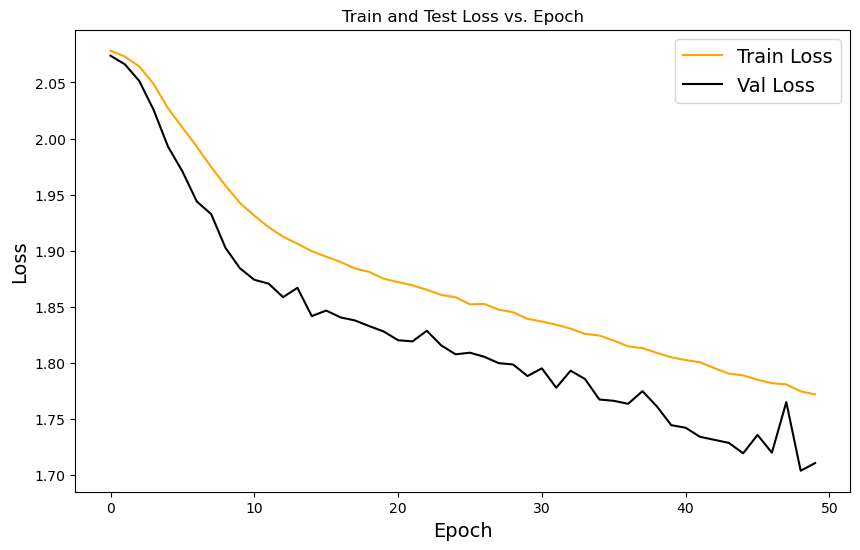

In [10]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10,6))

plt.plot(train_loss, label="Train Loss", color="orange")
plt.plot(val_loss, label="Val Loss", color="black")
plt.title("Train and Test Loss vs. Epoch")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=14)

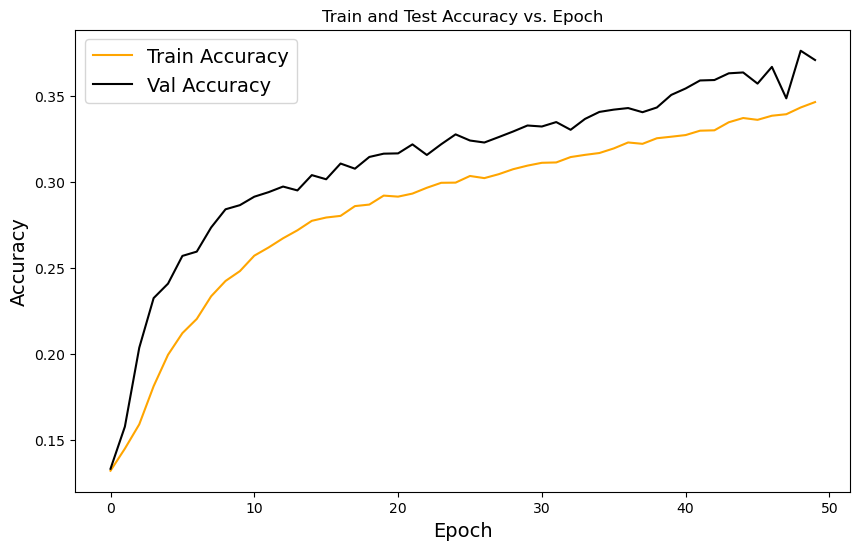

In [11]:
train_loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

plt.figure(figsize=(10,6))

plt.plot(train_loss, label="Train Accuracy", color="orange")
plt.plot(val_loss, label="Val Accuracy", color="black")
plt.title("Train and Test Accuracy vs. Epoch")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(fontsize=14)